In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [2]:
base = pd.read_csv('petr4_treinamento.csv')
base = base.dropna()
base.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.990000,20.209999,19.690001,19.690001,18.086271,30182600.0
1,2013-01-03,19.809999,20.400000,19.700001,20.400000,18.738441,30552600.0
2,2013-01-04,20.330000,20.620001,20.170000,20.430000,18.766001,36141000.0


In [3]:
base.tail(3)

,Date,Open,High,Low,Close,Adj Close,Volume
1242,2017-12-27,15.99,16.139999,15.98,16.049999,16.017963,23552200.0
1243,2017-12-28,16.10,16.129999,16.00,16.100000,16.067865,19011500.0
1244,2017-12-29,16.10,16.100000,16.10,16.100000,16.067865,0.0


In [4]:
base_treinamento = base.iloc[:, 1:7].values

In [5]:
normalizador = MinMaxScaler(feature_range=(0,1))
base_treinamento_normalizada = normalizador.fit_transform(base_treinamento)

normalizador_previsao = MinMaxScaler(feature_range=(0,1))
normalizador_previsao.fit_transform(base_treinamento[:,0:1])

array([[0.76501938],
       [0.7562984 ],
       [0.78149225],
       ...,
       [0.57122093],
       [0.57655039],
       [0.57655039]])

In [6]:
base.shape

(1242, 7)

In [7]:
base_treinamento_normalizada.shape

(1242, 6)

In [9]:
previsores = []
preco_real = []
for i in range(90, 1242):
    previsores.append(base_treinamento_normalizada[i-90:i, 0:6])
    preco_real.append(base_treinamento_normalizada[i, 0])
previsores, preco_real = np.array(previsores), np.array(preco_real)
previsores.shape

(1152, 90, 6)

In [10]:
regressor = Sequential()
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (previsores.shape[1], 6)))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.3))

regressor.add(Dense(units = 1, activation = 'sigmoid'))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error',
                  metrics = ['mean_absolute_error'])

regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 90, 100)           42800     
_________________________________________________________________
dropout (Dropout)            (None, 90, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 90, 50)            30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 90, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 90, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 90, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [11]:
es = EarlyStopping(monitor = 'loss', min_delta = 1e-10, patience = 10, verbose = 1)

rlr = ReduceLROnPlateau(monitor = 'loss', factor = 0.2, patience = 5, verbose = 1)

mcp = ModelCheckpoint(filepath = 'pesos.h5', monitor = 'loss', 
                      save_best_only = True, verbose = 1)

regressor.fit(previsores, preco_real, epochs = 100, batch_size = 32,
              callbacks = [es, rlr, mcp])

Epoch 1/100
36/36 [==============================] - ETA: 0s - loss: 0.0163 - mean_absolute_error: 0.0947
Epoch 00001: loss improved from inf to 0.01627, saving model to pesos.h5
36/36 [==============================] - 5s 144ms/step - loss: 0.0163 - mean_absolute_error: 0.0947
Epoch 2/100
36/36 [==============================] - ETA: 0s - loss: 0.0052 - mean_absolute_error: 0.0563
Epoch 00002: loss improved from 0.01627 to 0.00516, saving model to pesos.h5
36/36 [==============================] - 5s 136ms/step - loss: 0.0052 - mean_absolute_error: 0.0563
Epoch 3/100
36/36 [==============================] - ETA: 0s - loss: 0.0041 - mean_absolute_error: 0.0500
Epoch 00003: loss improved from 0.00516 to 0.00409, saving model to pesos.h5
36/36 [==============================] - 5s 136ms/step - loss: 0.0041 - mean_absolute_error: 0.0500
Epoch 4/100
36/36 [==============================] - ETA: 0s - loss: 0.0040 - mean_absolute_error: 0.0496
Epoch 00004: loss improved from 0.00409 to 0.0039

In [12]:
base_teste = pd.read_csv('petr4_teste.csv')
base_teste.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,16.190001,16.549999,16.190001,16.549999,16.516966,33461800
1,2018-01-03,16.490000,16.719999,16.370001,16.700001,16.666668,55940900
2,2018-01-04,16.780001,16.959999,16.620001,16.730000,16.696608,37064900


In [13]:
base_teste.tail(3)

,Date,Open,High,Low,Close,Adj Close,Volume
19,2018-01-29,19.67,20.049999,19.570000,19.850000,19.810381,55726200
20,2018-01-30,19.77,19.770000,19.360001,19.490000,19.451097,46203000
21,2018-01-31,19.74,19.930000,19.680000,19.700001,19.660681,41576600


In [14]:
preco_real_teste = base_teste.iloc[:, 1:2].values
frames = [base, base_teste]
base_completa = pd.concat(frames)
base_completa = base_completa.drop('Date', axis = 1)

In [15]:
entradas = base_completa[len(base_completa) - len(base_teste) - 90:].values
entradas = normalizador.transform(entradas)

In [18]:
base_teste.shape

(22, 7)

In [16]:
entradas.shape

(112, 6)

In [17]:
X_teste = []
for i in range(90, 112):
    X_teste.append(entradas[i-90:i, 0:6])
X_teste = np.array(X_teste)
X_teste.shape

(22, 90, 6)

In [19]:
previsoes = regressor.predict(X_teste)
previsoes = normalizador_previsao.inverse_transform(previsoes)

In [21]:
print(previsoes.mean())
print(preco_real_teste.mean())

17.62474
17.87454563636364


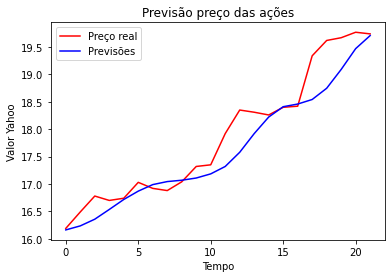

In [23]:
plt.plot(preco_real_teste, color = 'red', label = 'Preço real')
plt.plot(previsoes, color = 'blue', label = 'Previsões')
plt.title('Previsão preço das ações')
plt.xlabel('Tempo')
plt.ylabel('Valor Yahoo')
plt.legend()
plt.show()